# Baseline models training

Notebook contains training and validation of XGBoost models without any previous experiments on data.  We check 4 different prediction cases:
- All cancer types together, multiclass classification (stages: I, II, III, IV)
- All cancer types together, binary classification (stages: I-III vs IV)
- Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)
- Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

Outcomes can be treated as baseline results.

In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Define directory paths to save results

In [3]:
output_dir_multiclass = '../results/updated_data/all_features/baseline_models/multiclass/'
output_dir_binary = '../results/updated_data/all_features/baseline_models/binary/'

Load training data

In [4]:
data_path = '../data/cleaned/updated/stable_features/'
models_path = '../models'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Columns: 762 entries, ID to NDUFA4
dtypes: float64(758), object(4)
memory usage: 5.1+ MB


Define functions for cross-validation in a stratified way: one for hyperparameters optimization (returns only mean score) and a second for validation of the model with best params (returns predictions)

In [5]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)
        y_pred[test_index] = estimator.predict(X.iloc[test_index])

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [6]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=4
    )

    return scores.mean()

Define function for plotting confusion matrix

In [7]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha='right', rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

### All cancer types together, multiclass classification (stages: I, II, III, IV)

Extract cancer types and stages to perform cross validation in a stratified way

Remove unnecessary columns: ID, Group, Sex and Age

Encode labels

In [8]:
X_train = train.copy(deep=True)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
cancer_types = X_train['Group']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

3    539
2    149
1    113
0     69
Name: Stage, dtype: int64

Since the classes are pretty imbalanced we use the weighted-average F1 metric for optimization

In [9]:
xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 01:23:26,919] A new study created in memory with name: no-name-36a630b5-a82f-4fa9-af2b-da5461dfbc22
[I 2023-10-21 01:23:33,891] Trial 0 finished with value: 0.2624145962449397 and parameters: {'n_estimators': 134, 'max_depth': 8, 'learning_rate': 0.4011078041931658, 'subsample': 0.6856334989273454, 'colsample_bytree': 0.59302666517303, 'gamma': 0.7773538771346561}. Best is trial 0 with value: 0.2624145962449397.
[I 2023-10-21 01:23:37,102] Trial 1 finished with value: 0.2740692542401577 and parameters: {'n_estimators': 55, 'max_depth': 6, 'learning_rate': 0.3135596647551846, 'subsample': 0.8774805624238584, 'colsample_bytree': 0.91864851160172, 'gamma': 3.139050459496098}. Best is trial 1 with value: 0.2740692542401577.
[I 2023-10-21 01:23:46,321] Trial 2 finished with value: 0.2658747050889111 and parameters: {'n_estimators': 76, 'max_depth': 6, 'learning_rate': 0.023918396105760284, 'subsample': 0.8263281451044353, 'colsample_bytree': 0.5561571300858799, 'gamma': 2.2186

[I 2023-10-21 01:25:30,458] Trial 25 finished with value: 0.28399996340478395 and parameters: {'n_estimators': 131, 'max_depth': 3, 'learning_rate': 0.4641811740456657, 'subsample': 0.6594424350027382, 'colsample_bytree': 0.7488924210611545, 'gamma': 1.0763340617926478}. Best is trial 23 with value: 0.32337279410184017.
[I 2023-10-21 01:25:40,490] Trial 26 finished with value: 0.30543043503989975 and parameters: {'n_estimators': 118, 'max_depth': 2, 'learning_rate': 0.4951429230426798, 'subsample': 0.6319249487615075, 'colsample_bytree': 0.7052521228748277, 'gamma': 0.019643797577139743}. Best is trial 23 with value: 0.32337279410184017.
[I 2023-10-21 01:25:50,972] Trial 27 finished with value: 0.308093043464021 and parameters: {'n_estimators': 138, 'max_depth': 3, 'learning_rate': 0.4464911195557222, 'subsample': 0.7215319777839535, 'colsample_bytree': 0.7471851338592174, 'gamma': 2.096918434949901}. Best is trial 23 with value: 0.32337279410184017.
[I 2023-10-21 01:26:02,032] Trial 2

[I 2023-10-21 01:29:44,318] Trial 50 finished with value: 0.2937600021891722 and parameters: {'n_estimators': 108, 'max_depth': 8, 'learning_rate': 0.4296282666343909, 'subsample': 0.803545608740847, 'colsample_bytree': 0.7785787921457705, 'gamma': 1.9750039973549922}. Best is trial 23 with value: 0.32337279410184017.
[I 2023-10-21 01:29:52,953] Trial 51 finished with value: 0.2975968480171459 and parameters: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.47291606795510116, 'subsample': 0.7179458364788027, 'colsample_bytree': 0.8246385289093288, 'gamma': 0.7294153472202425}. Best is trial 23 with value: 0.32337279410184017.
[I 2023-10-21 01:30:02,024] Trial 52 finished with value: 0.3115707836754021 and parameters: {'n_estimators': 117, 'max_depth': 2, 'learning_rate': 0.4785037973942737, 'subsample': 0.7576296172533463, 'colsample_bytree': 0.8551701573651318, 'gamma': 0.5909429335116492}. Best is trial 23 with value: 0.32337279410184017.
[I 2023-10-21 01:30:10,609] Trial 53 

[I 2023-10-21 01:33:29,210] Trial 75 finished with value: 0.29861919311997887 and parameters: {'n_estimators': 132, 'max_depth': 2, 'learning_rate': 0.4888913384157956, 'subsample': 0.8124094334377006, 'colsample_bytree': 0.7516959741977096, 'gamma': 1.3447022453834983}. Best is trial 63 with value: 0.3302885808265758.
[I 2023-10-21 01:33:38,247] Trial 76 finished with value: 0.311350675107378 and parameters: {'n_estimators': 141, 'max_depth': 3, 'learning_rate': 0.4659698635270875, 'subsample': 0.7957520583919446, 'colsample_bytree': 0.78393566516236, 'gamma': 0.9076189293796058}. Best is trial 63 with value: 0.3302885808265758.
[I 2023-10-21 01:33:47,469] Trial 77 finished with value: 0.32129170174547994 and parameters: {'n_estimators': 127, 'max_depth': 2, 'learning_rate': 0.4341751383993435, 'subsample': 0.7663177998049199, 'colsample_bytree': 0.76091695704754, 'gamma': 1.1389628115385624}. Best is trial 63 with value: 0.3302885808265758.
[I 2023-10-21 01:33:56,923] Trial 78 finish

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [10]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.43      0.13      0.20        69
          II       0.23      0.10      0.14       113
         III       0.26      0.15      0.19       149
          IV       0.69      0.91      0.79       539

    accuracy                           0.62       870
   macro avg       0.40      0.32      0.33       870
weighted avg       0.54      0.62      0.56       870



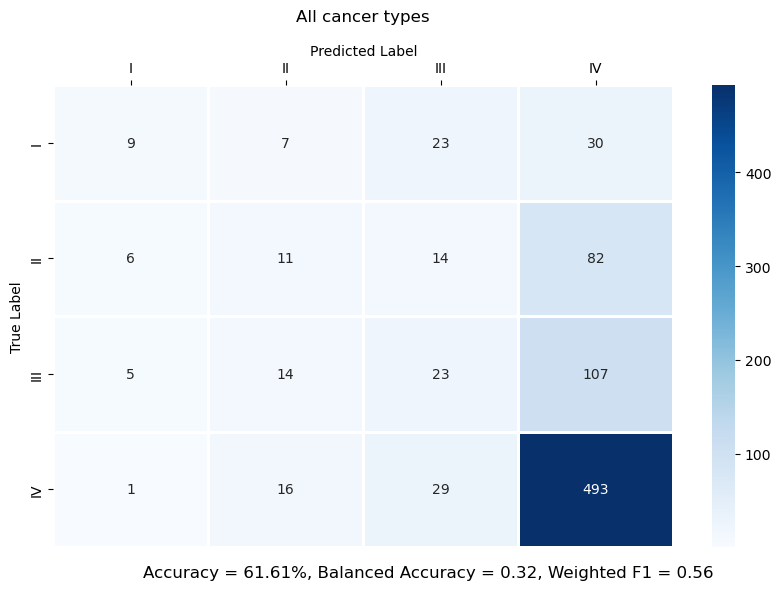

In [11]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'All cancer types'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'all_cancer_types.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

Check model performance for each cancer type separately

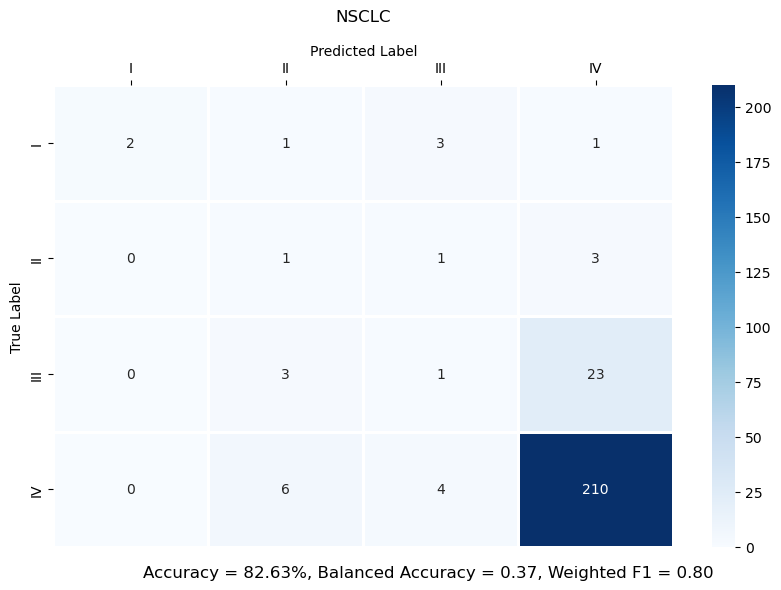

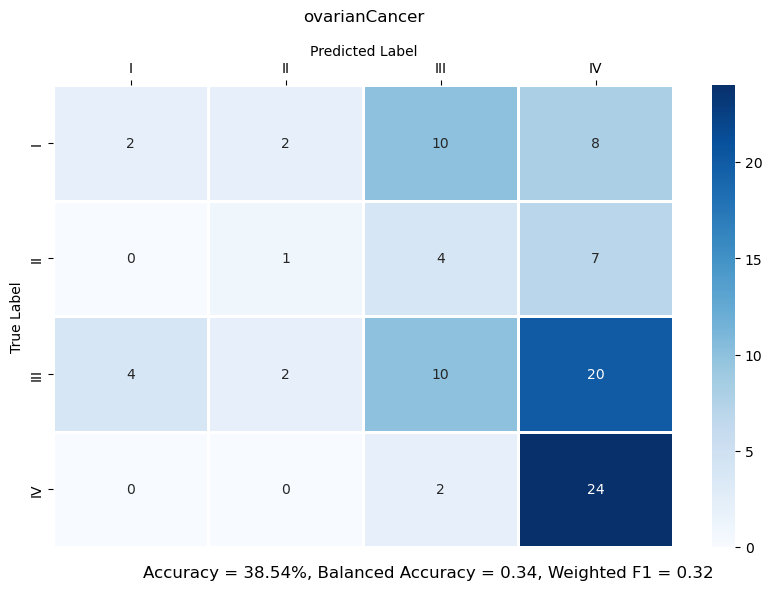

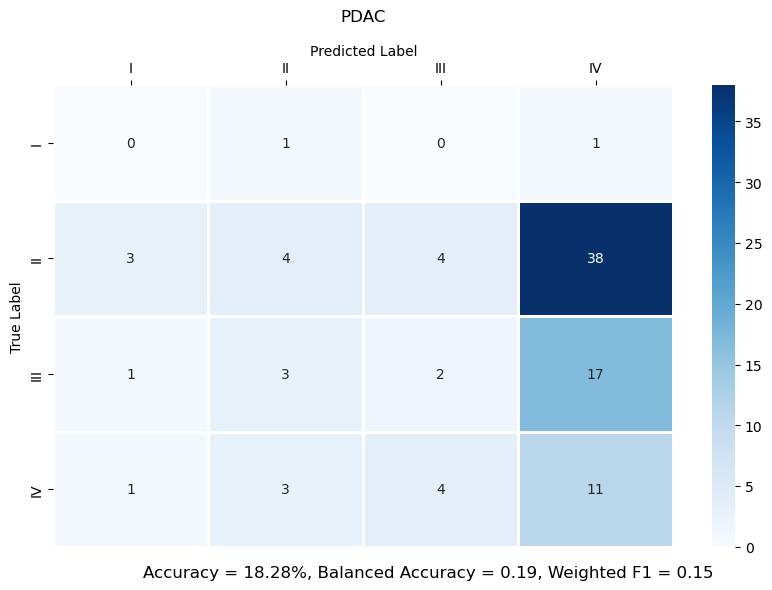

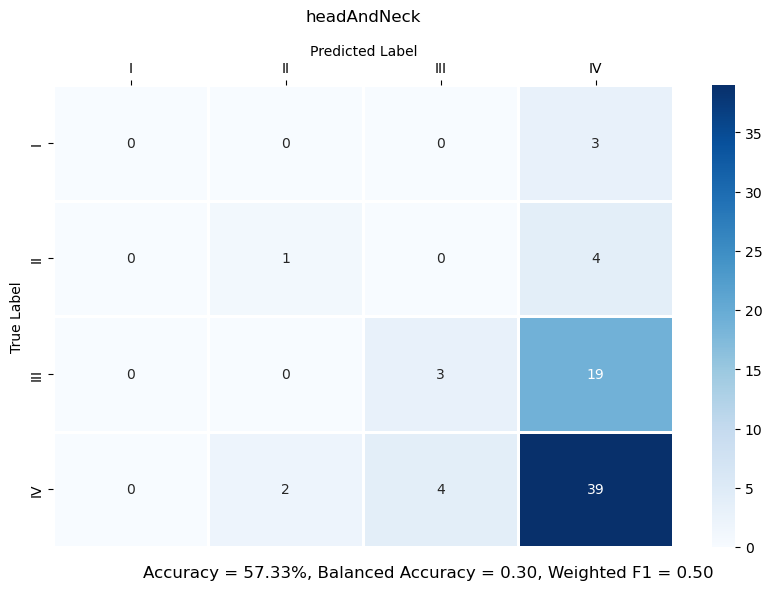

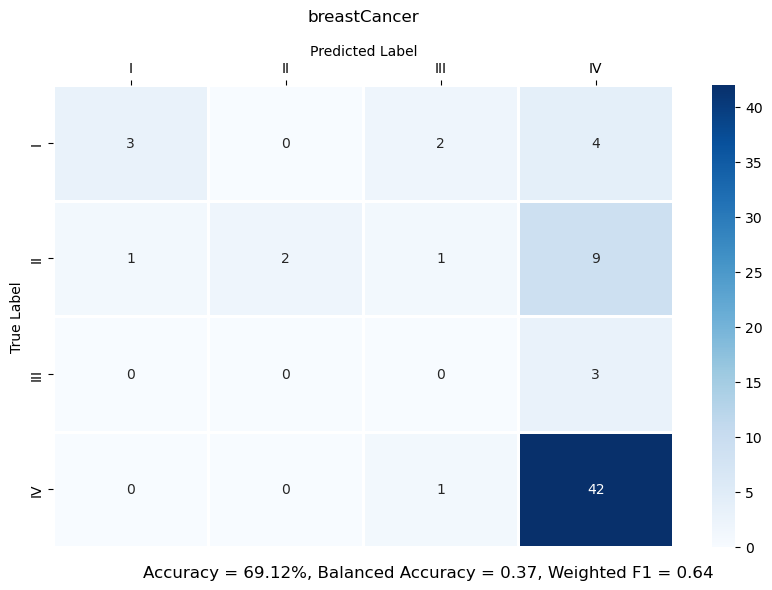

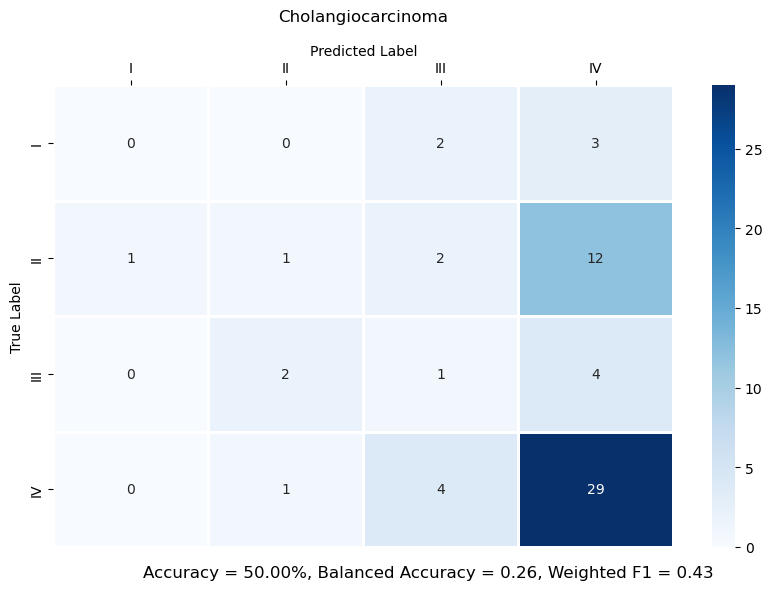

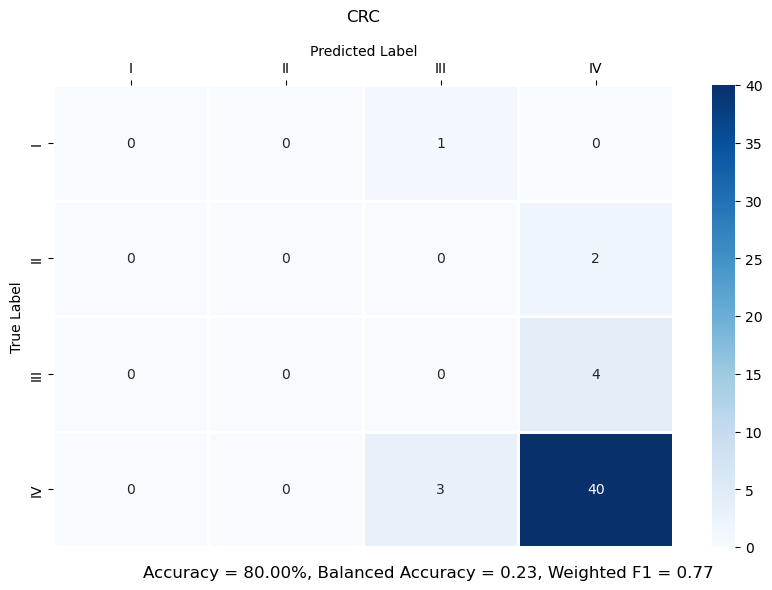

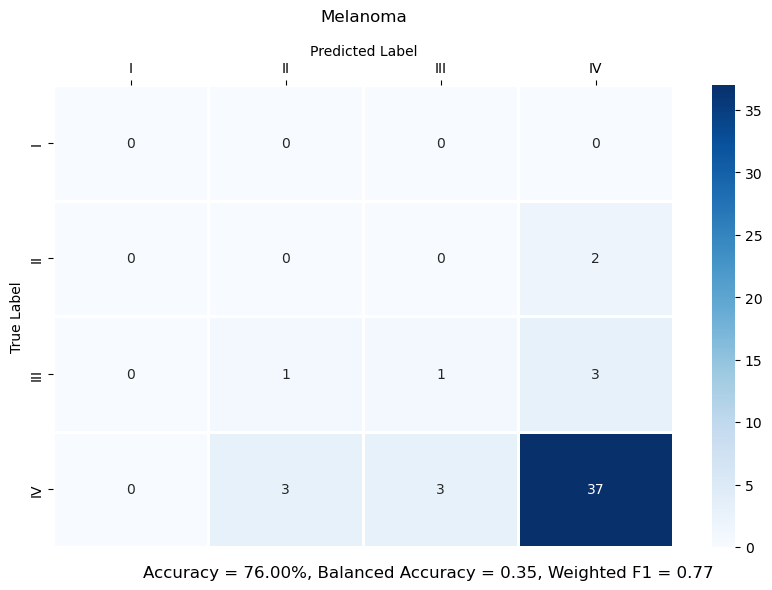

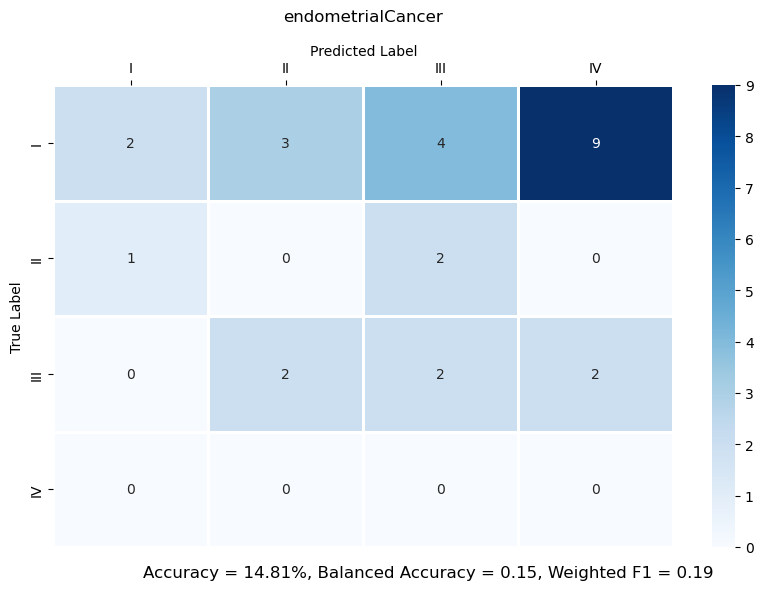

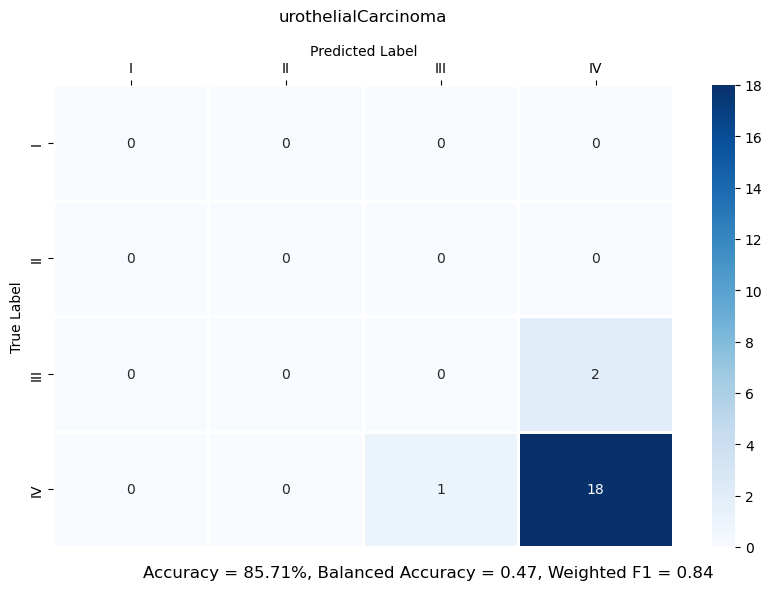

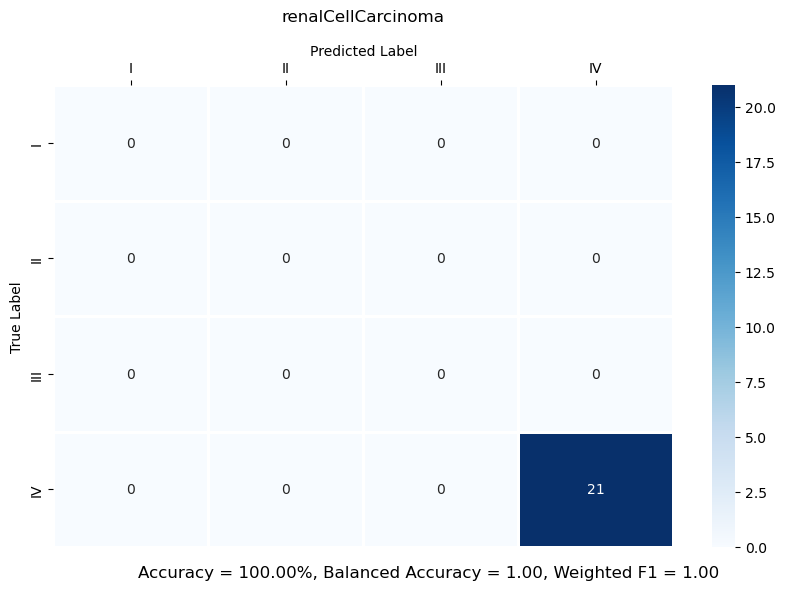

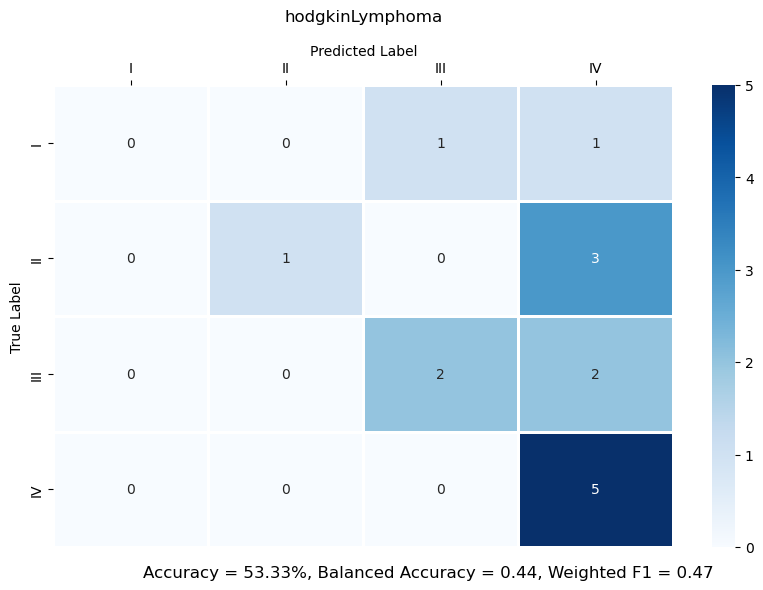

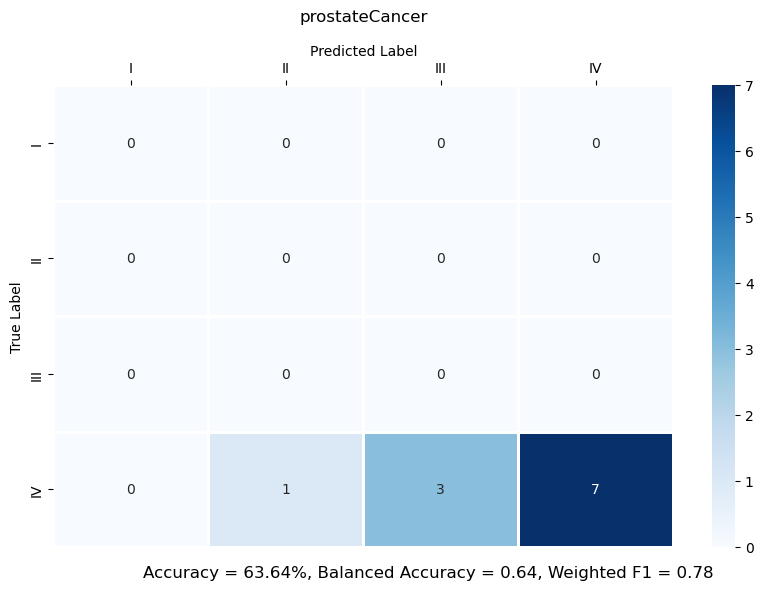

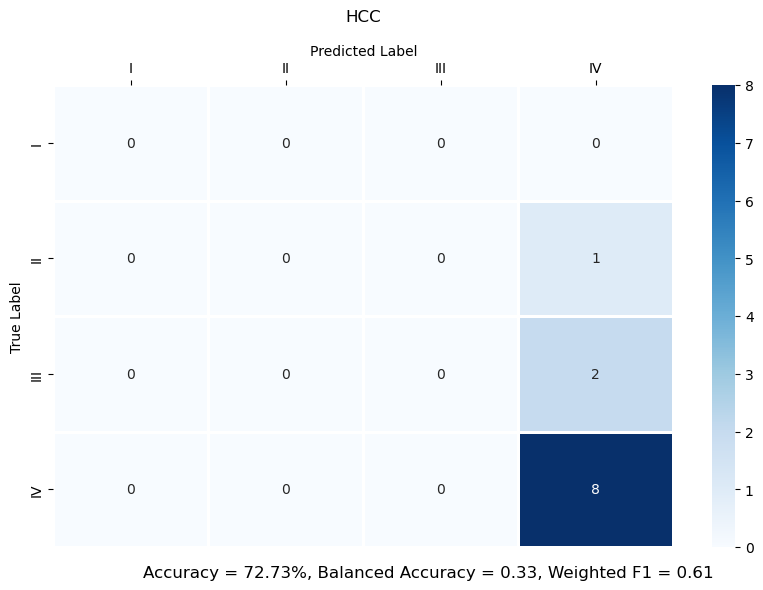

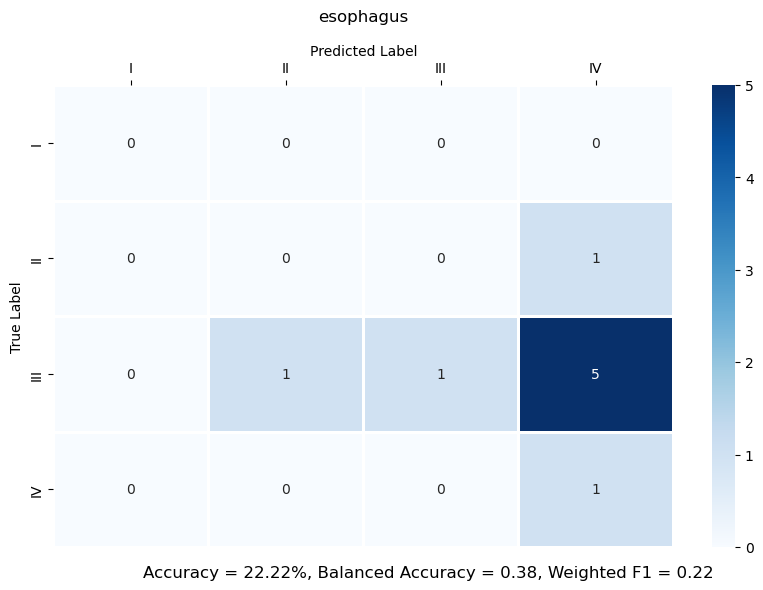

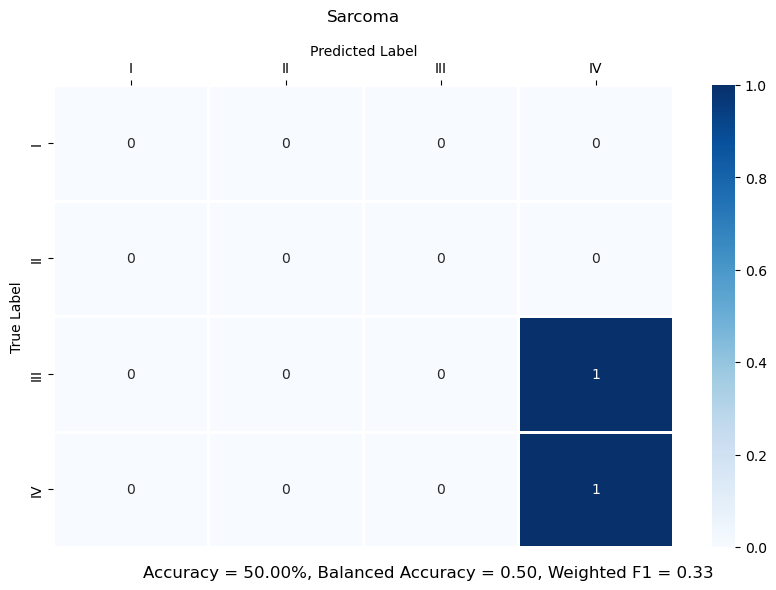

In [12]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'], average='weighted')
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1, 2, 3])

    title = group_name
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    filename = f'all_cancer_types_only_{group_name.lower().replace(" ", "_")}_results.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

## All cancer types together, binary classification (stages: I-III vs IV)

Map first three stages to one mutual class "I-III"

Encode labels

In [13]:
X_train = train.copy(deep=True)

mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train = X_train.loc[:, ~train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I-III': 0,
    'IV': 1
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

1    539
0    331
Name: Stage, dtype: int64

Run hyperparameters optimization

In [14]:
xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 01:37:26,696] A new study created in memory with name: no-name-bf666c07-6b8c-4100-8f34-82a2ae5418cc
[I 2023-10-21 01:37:30,062] Trial 0 finished with value: 0.6485663911950924 and parameters: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.18325441335696288, 'subsample': 0.8394521493250268, 'colsample_bytree': 0.7309427948118588, 'gamma': 4.137958748232474}. Best is trial 0 with value: 0.6485663911950924.
[I 2023-10-21 01:37:40,019] Trial 1 finished with value: 0.6588497528358858 and parameters: {'n_estimators': 89, 'max_depth': 8, 'learning_rate': 0.05561051576145814, 'subsample': 0.7491896024344076, 'colsample_bytree': 0.7867835038907344, 'gamma': 0.4354136852757773}. Best is trial 1 with value: 0.6588497528358858.
[I 2023-10-21 01:37:42,937] Trial 2 finished with value: 0.6457926217213802 and parameters: {'n_estimators': 54, 'max_depth': 6, 'learning_rate': 0.28452767975526916, 'subsample': 0.5129593235755417, 'colsample_bytree': 0.5899518320929926, 'gamma': 2

[I 2023-10-21 01:39:41,202] Trial 25 finished with value: 0.6551775569416339 and parameters: {'n_estimators': 144, 'max_depth': 2, 'learning_rate': 0.33170294240868525, 'subsample': 0.7535116150223051, 'colsample_bytree': 0.9204858743024229, 'gamma': 0.7416553121791651}. Best is trial 24 with value: 0.6691721836290939.
[I 2023-10-21 01:39:45,697] Trial 26 finished with value: 0.6480682865747771 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.20327762040175462, 'subsample': 0.783809936589468, 'colsample_bytree': 0.9525685422801142, 'gamma': 1.3510925256566126}. Best is trial 24 with value: 0.6691721836290939.
[I 2023-10-21 01:39:49,116] Trial 27 finished with value: 0.6211788242091221 and parameters: {'n_estimators': 73, 'max_depth': 3, 'learning_rate': 0.22118022340449184, 'subsample': 0.7307078451841227, 'colsample_bytree': 0.9595117704831484, 'gamma': 0.8947313488265094}. Best is trial 24 with value: 0.6691721836290939.
[I 2023-10-21 01:39:52,548] Trial 28 fi

[I 2023-10-21 01:41:43,651] Trial 50 finished with value: 0.6418024523123267 and parameters: {'n_estimators': 149, 'max_depth': 6, 'learning_rate': 0.2723082531627003, 'subsample': 0.755815426936725, 'colsample_bytree': 0.9858386560787955, 'gamma': 0.2449441257611525}. Best is trial 24 with value: 0.6691721836290939.
[I 2023-10-21 01:41:50,077] Trial 51 finished with value: 0.6684670168889156 and parameters: {'n_estimators': 128, 'max_depth': 4, 'learning_rate': 0.41629886601612553, 'subsample': 0.7154434431182829, 'colsample_bytree': 0.9397718743777738, 'gamma': 0.02025203724118463}. Best is trial 24 with value: 0.6691721836290939.
[I 2023-10-21 01:41:55,451] Trial 52 finished with value: 0.6678760375575169 and parameters: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.38657323444242697, 'subsample': 0.7279808499692864, 'colsample_bytree': 0.9402900316732017, 'gamma': 0.4668969585077435}. Best is trial 24 with value: 0.6691721836290939.
[I 2023-10-21 01:42:00,439] Trial 53 f

[I 2023-10-21 01:43:57,084] Trial 75 finished with value: 0.6589727324507504 and parameters: {'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.4350930983787437, 'subsample': 0.7935263015065517, 'colsample_bytree': 0.9402192935875804, 'gamma': 0.13852651833517476}. Best is trial 24 with value: 0.6691721836290939.
[I 2023-10-21 01:44:02,472] Trial 76 finished with value: 0.6354336574515665 and parameters: {'n_estimators': 141, 'max_depth': 4, 'learning_rate': 0.39373835116443806, 'subsample': 0.7684921317171093, 'colsample_bytree': 0.9209193771511842, 'gamma': 0.6634080300613316}. Best is trial 24 with value: 0.6691721836290939.
[I 2023-10-21 01:44:07,533] Trial 77 finished with value: 0.6543377692163075 and parameters: {'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.34960477035479237, 'subsample': 0.8046526103983594, 'colsample_bytree': 0.967913207707362, 'gamma': 0.40815366252206564}. Best is trial 24 with value: 0.6691721836290939.
[I 2023-10-21 01:44:13,385] Trial 78 

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [15]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.58      0.50      0.54       331
          IV       0.72      0.78      0.75       539

    accuracy                           0.67       870
   macro avg       0.65      0.64      0.64       870
weighted avg       0.67      0.67      0.67       870



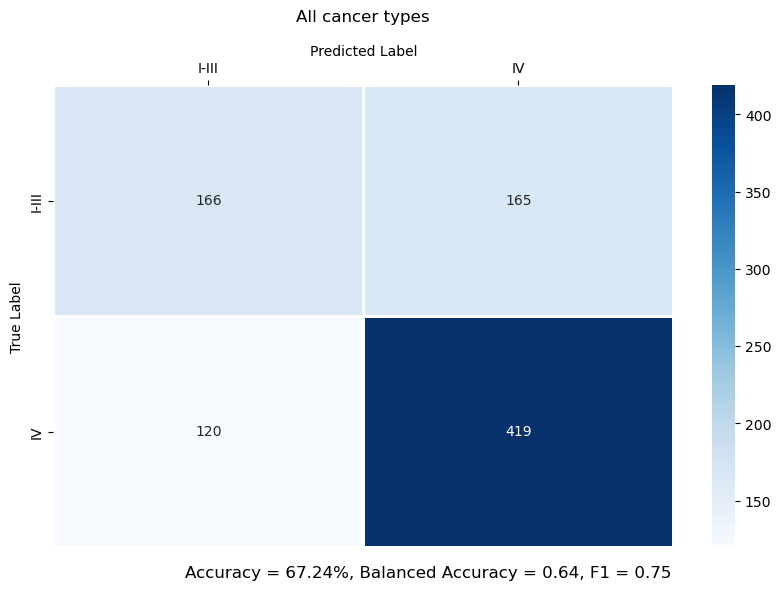

In [16]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'All cancer types'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

filename = f'all_cancer_types.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

Check model performance for each cancer type separately

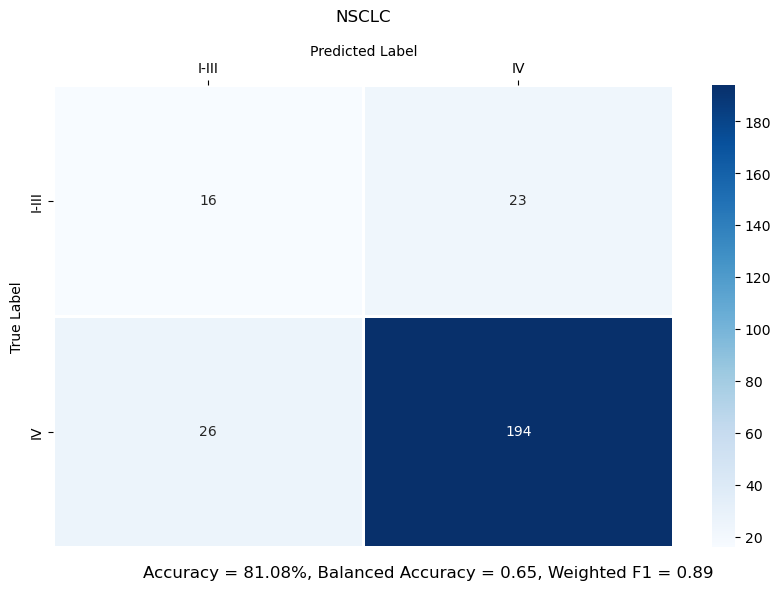

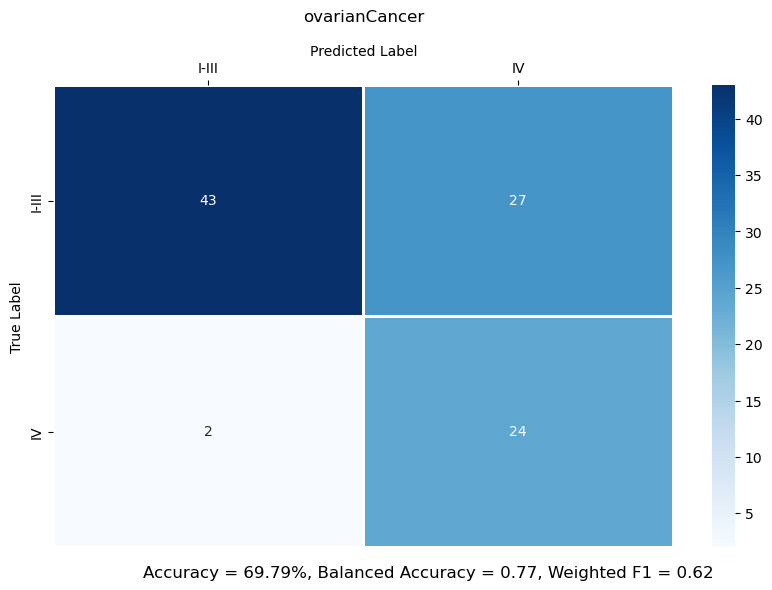

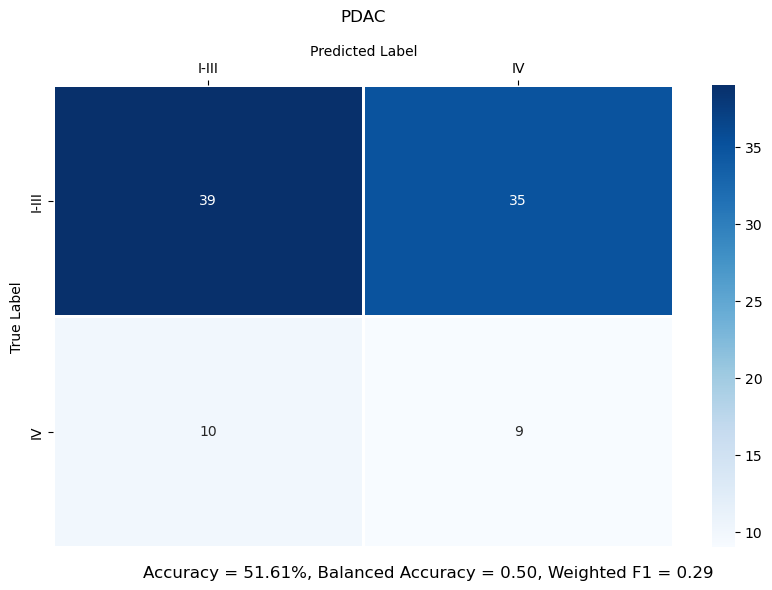

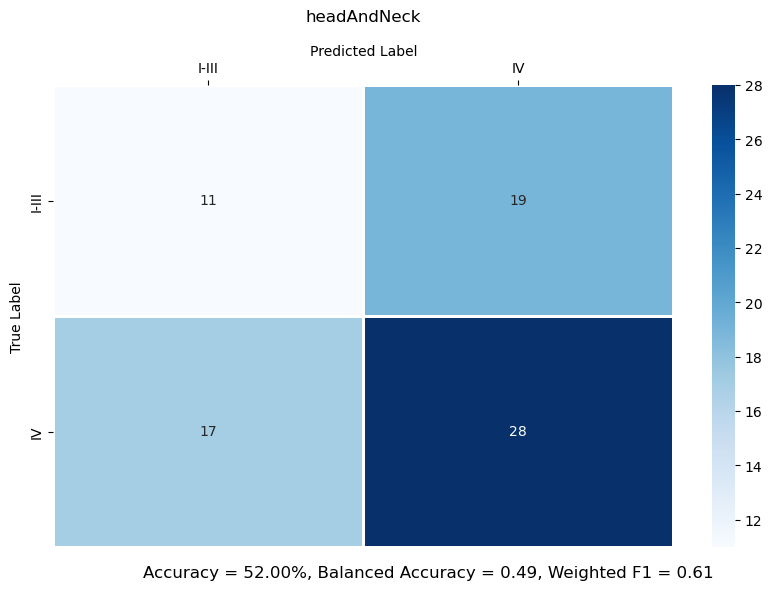

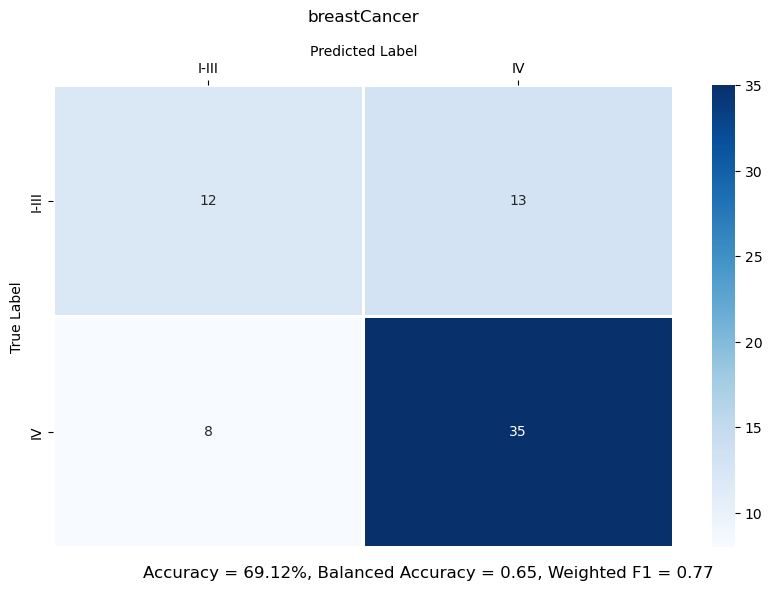

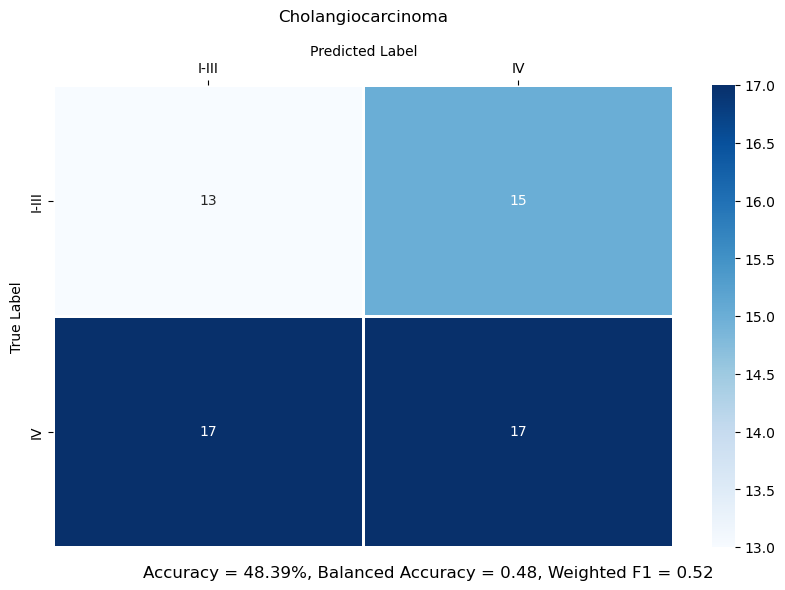

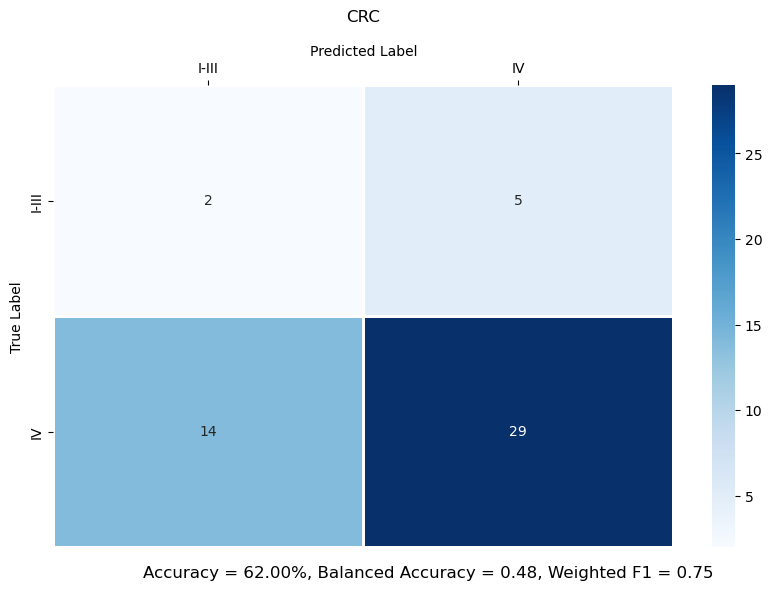

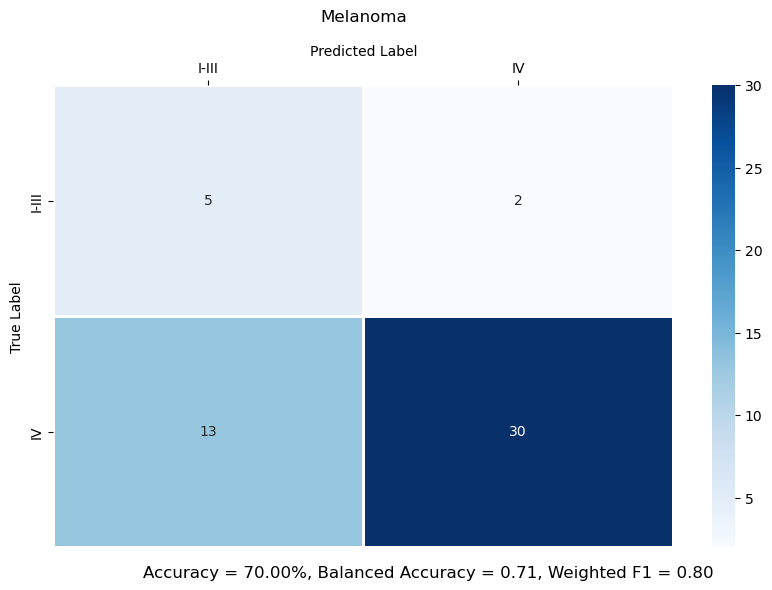

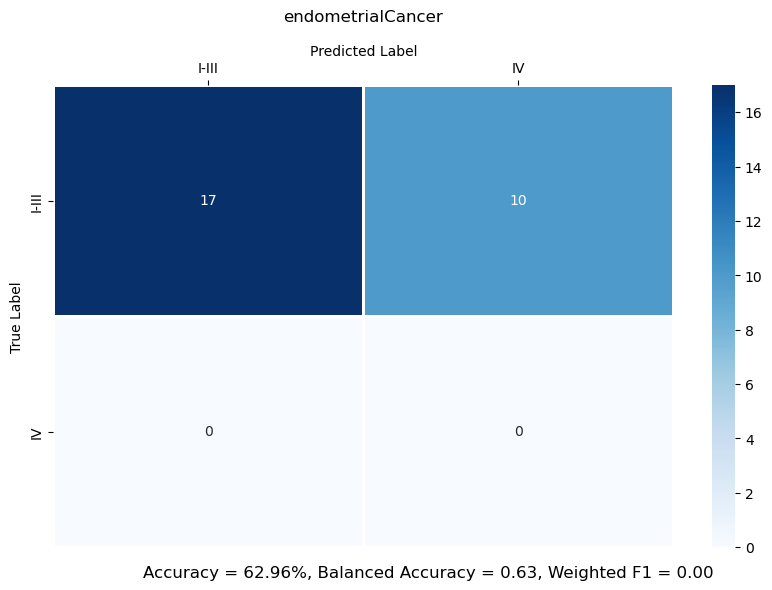

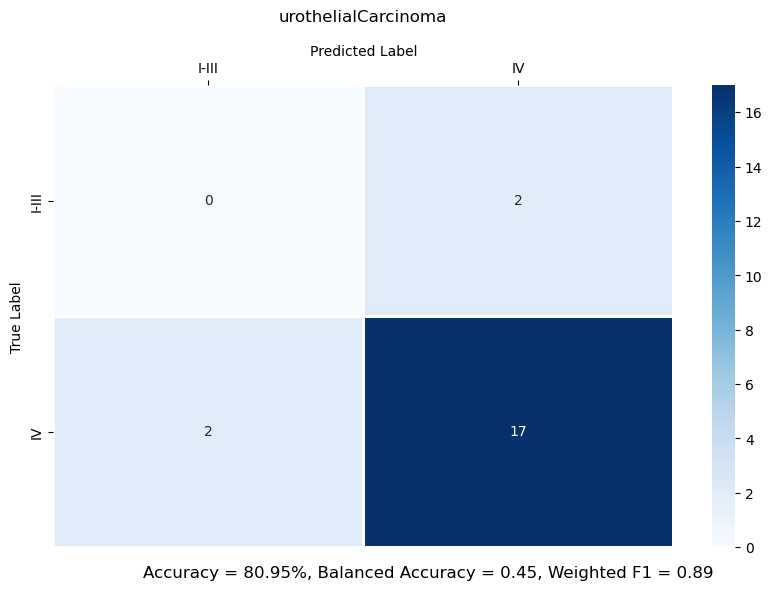

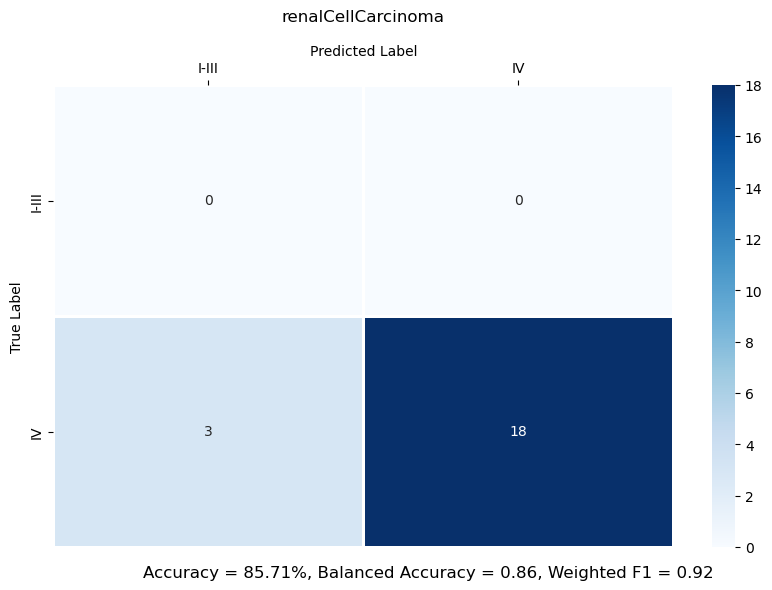

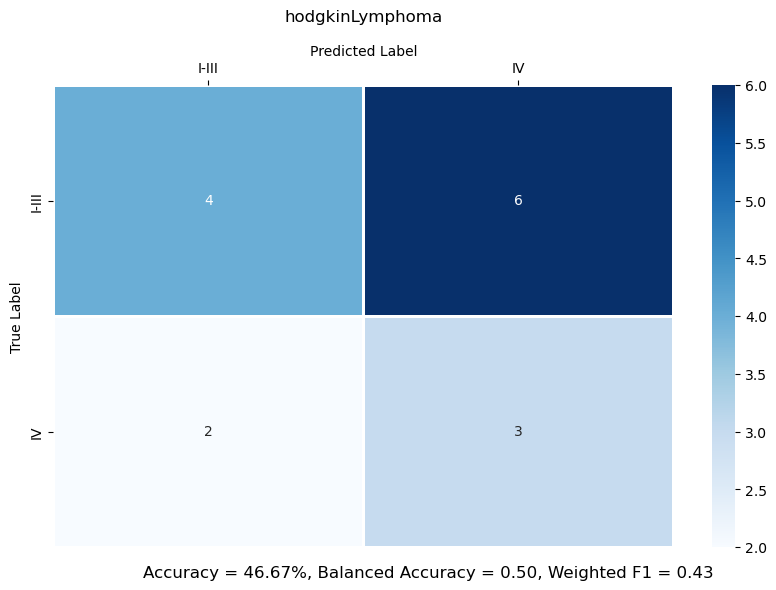

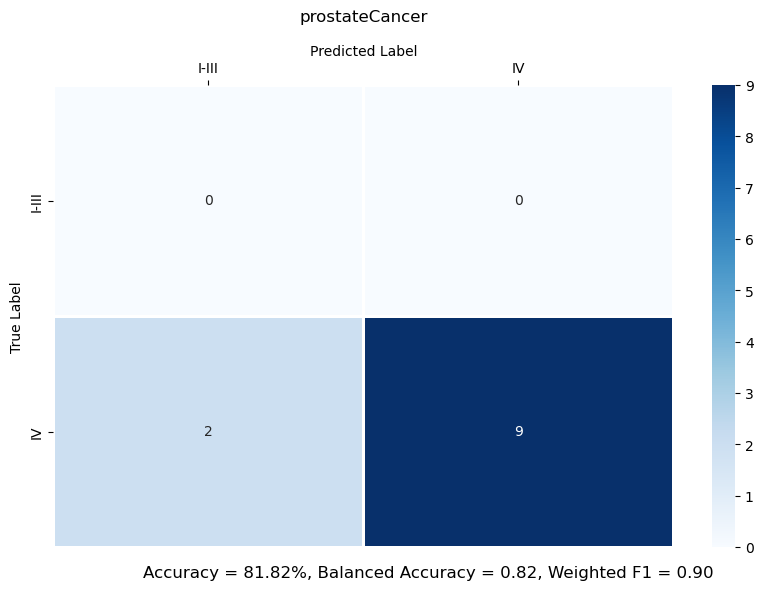

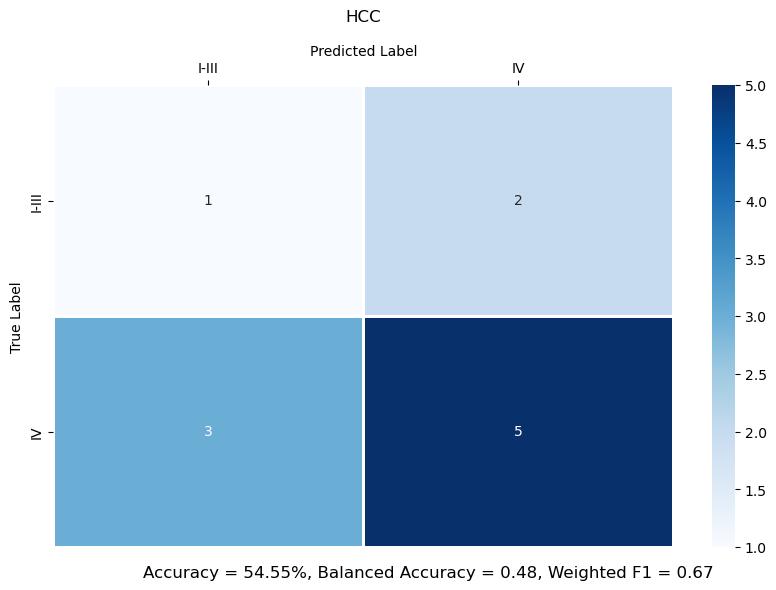

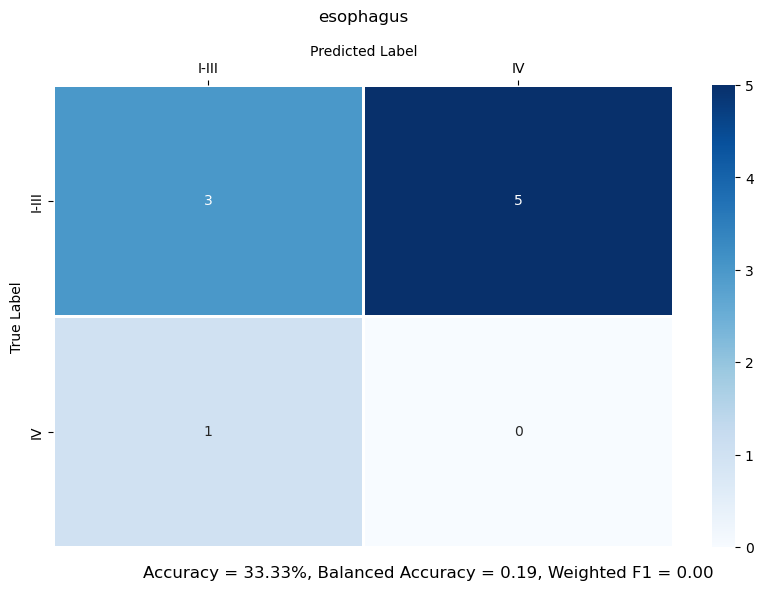

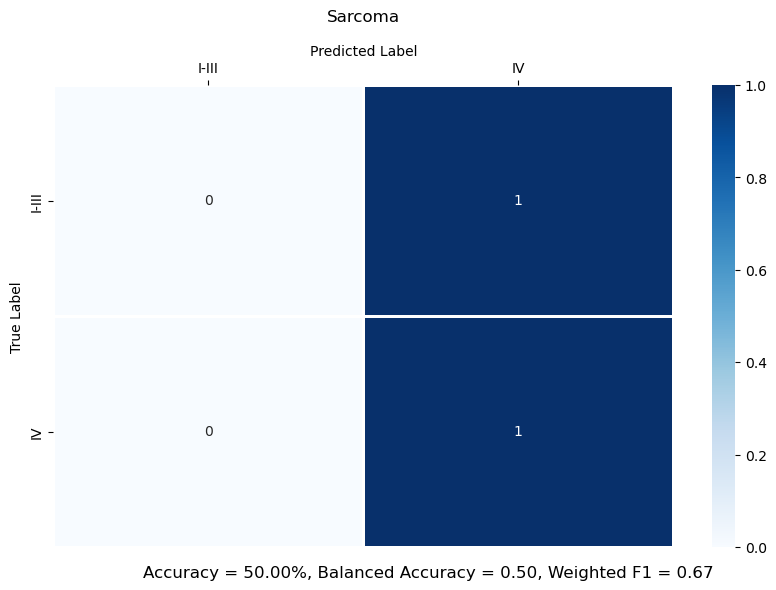

In [17]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'])
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1])

    title = group_name
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    filename = f'all_cancer_types_only_{group_name.lower().replace(" ", "_")}_results.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

## Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)

In [18]:
labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}

xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'num_class': 4,
}

scoring_func = balanced_accuracy_score

Get only the most numerous cancer types (with more than 90 cases)

In [19]:
cancer_type_counts = train['Group'].value_counts()
numerous_cancer_types = cancer_type_counts[cancer_type_counts > 90].index.tolist()
numerous_cancer_types

['NSCLC', 'ovarianCancer', 'PDAC']

For each cancer type a separate model will be created, optimized and tested

### NSCLC

In [20]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

3    220
2     27
0      7
1      5
Name: Stage, dtype: int64

In [21]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 01:45:57,192] A new study created in memory with name: no-name-4a8cb79d-eb87-4bd6-9bc5-0ee3ac649a72
[I 2023-10-21 01:46:04,661] Trial 0 finished with value: 0.3113636363636364 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.40139480879311035, 'subsample': 0.7177357680626828, 'colsample_bytree': 0.5153131488177854, 'gamma': 4.1514864719039855}. Best is trial 0 with value: 0.3113636363636364.
[I 2023-10-21 01:46:12,967] Trial 1 finished with value: 0.3214285714285714 and parameters: {'n_estimators': 127, 'max_depth': 8, 'learning_rate': 0.18265966139038955, 'subsample': 0.6912880649222861, 'colsample_bytree': 0.5614433469208222, 'gamma': 0.4396134295413562}. Best is trial 1 with value: 0.3214285714285714.
[I 2023-10-21 01:46:20,368] Trial 2 finished with value: 0.28790584415584414 and parameters: {'n_estimators': 113, 'max_depth': 8, 'learning_rate': 0.41905272624511575, 'subsample': 0.6682190869302553, 'colsample_bytree': 0.7260516108855237, 'gamma

[I 2023-10-21 01:49:03,192] Trial 25 finished with value: 0.2901785714285714 and parameters: {'n_estimators': 148, 'max_depth': 4, 'learning_rate': 0.14185260510167358, 'subsample': 0.925825802556725, 'colsample_bytree': 0.9293132787360003, 'gamma': 0.714423525012602}. Best is trial 10 with value: 0.3827922077922078.
[I 2023-10-21 01:49:09,655] Trial 26 finished with value: 0.34375 and parameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.09851089460777976, 'subsample': 0.9641699209636206, 'colsample_bytree': 0.8700801904541092, 'gamma': 0.5173910284835881}. Best is trial 10 with value: 0.3827922077922078.
[I 2023-10-21 01:49:16,588] Trial 27 finished with value: 0.28125 and parameters: {'n_estimators': 87, 'max_depth': 2, 'learning_rate': 0.001419478622147946, 'subsample': 0.8475362776493086, 'colsample_bytree': 0.9627792090186446, 'gamma': 0.9297238895794022}. Best is trial 10 with value: 0.3827922077922078.
[I 2023-10-21 01:49:26,833] Trial 28 finished with value: 0.3

[I 2023-10-21 01:53:04,655] Trial 51 finished with value: 0.3839285714285714 and parameters: {'n_estimators': 122, 'max_depth': 3, 'learning_rate': 0.03218985825069723, 'subsample': 0.9124890853279075, 'colsample_bytree': 0.9791654277414339, 'gamma': 0.8097088004151327}. Best is trial 32 with value: 0.4151785714285714.
[I 2023-10-21 01:53:12,561] Trial 52 finished with value: 0.3526785714285714 and parameters: {'n_estimators': 119, 'max_depth': 3, 'learning_rate': 0.07639723251957342, 'subsample': 0.9162648973413086, 'colsample_bytree': 0.9506518343561219, 'gamma': 0.7292369201577085}. Best is trial 32 with value: 0.4151785714285714.
[I 2023-10-21 01:53:26,005] Trial 53 finished with value: 0.4375 and parameters: {'n_estimators': 131, 'max_depth': 5, 'learning_rate': 0.034687480001504185, 'subsample': 0.9621270686692134, 'colsample_bytree': 0.9746539986528888, 'gamma': 0.4794290686576501}. Best is trial 53 with value: 0.4375.
[I 2023-10-21 01:53:37,931] Trial 54 finished with value: 0.

[I 2023-10-21 01:56:00,415] Trial 77 finished with value: 0.28125 and parameters: {'n_estimators': 123, 'max_depth': 2, 'learning_rate': 0.003915375042573711, 'subsample': 0.9523973116014066, 'colsample_bytree': 0.9885089964268361, 'gamma': 0.3123794818933871}. Best is trial 53 with value: 0.4375.
[I 2023-10-21 01:56:05,387] Trial 78 finished with value: 0.28125 and parameters: {'n_estimators': 136, 'max_depth': 4, 'learning_rate': 0.05362971461231049, 'subsample': 0.9200488044457722, 'colsample_bytree': 0.9477384140818714, 'gamma': 1.1576661214174582}. Best is trial 53 with value: 0.4375.
[I 2023-10-21 01:56:10,457] Trial 79 finished with value: 0.34375 and parameters: {'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.02519389818104461, 'subsample': 0.8939921844874391, 'colsample_bytree': 0.9721259992504215, 'gamma': 0.388716202597556}. Best is trial 53 with value: 0.4375.
[I 2023-10-21 01:56:14,473] Trial 80 finished with value: 0.3526785714285714 and parameters: {'n_estimator

In [22]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.75      0.43      0.55         7
          II       0.00      0.00      0.00         5
         III       0.50      0.04      0.07        27
          IV       0.87      1.00      0.93       220

    accuracy                           0.86       259
   macro avg       0.53      0.37      0.39       259
weighted avg       0.81      0.86      0.81       259



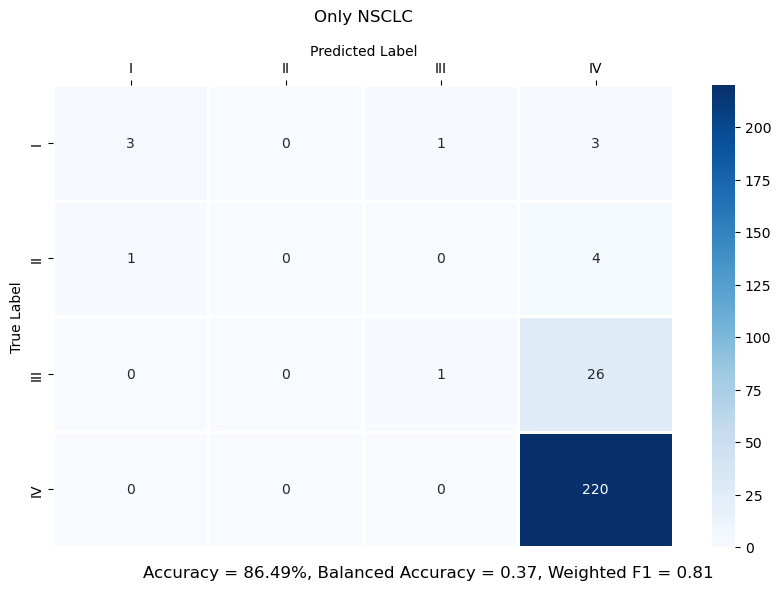

In [23]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'nsclc_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Ovarian cancer

In [26]:
X_train = train.loc[train['Group'] == 'ovarianCancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

2    36
3    26
0    22
1    12
Name: Stage, dtype: int64

In [27]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 12:02:13,545] A new study created in memory with name: no-name-c3b78e0e-8f28-4c51-803e-b224221d1ca3
[I 2023-10-21 12:02:16,643] Trial 0 finished with value: 0.39017857142857143 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.2613232194968611, 'subsample': 0.6527581229506738, 'colsample_bytree': 0.9171414790698534, 'gamma': 0.40614542128916853}. Best is trial 0 with value: 0.39017857142857143.
[I 2023-10-21 12:02:19,458] Trial 1 finished with value: 0.4214285714285714 and parameters: {'n_estimators': 102, 'max_depth': 8, 'learning_rate': 0.14373406637296207, 'subsample': 0.7208190074510306, 'colsample_bytree': 0.6651245417243195, 'gamma': 2.0852767422013967}. Best is trial 1 with value: 0.4214285714285714.
[I 2023-10-21 12:02:20,624] Trial 2 finished with value: 0.3741071428571429 and parameters: {'n_estimators': 23, 'max_depth': 2, 'learning_rate': 0.369789284057259, 'subsample': 0.8604057719491031, 'colsample_bytree': 0.9810636940460056, 'gamma':

[I 2023-10-21 12:03:22,321] Trial 25 finished with value: 0.41646825396825393 and parameters: {'n_estimators': 136, 'max_depth': 5, 'learning_rate': 0.21312443265859873, 'subsample': 0.8708992087470852, 'colsample_bytree': 0.8976927259160234, 'gamma': 0.4425921477131073}. Best is trial 9 with value: 0.4685515873015873.
[I 2023-10-21 12:03:25,525] Trial 26 finished with value: 0.4199404761904762 and parameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.1716504589112078, 'subsample': 0.7725936462134778, 'colsample_bytree': 0.8417213755049955, 'gamma': 0.44477391708442837}. Best is trial 9 with value: 0.4685515873015873.
[I 2023-10-21 12:03:28,972] Trial 27 finished with value: 0.3866071428571428 and parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.24261253453655462, 'subsample': 0.8273439922995213, 'colsample_bytree': 0.8842708047695604, 'gamma': 1.5267559398156156}. Best is trial 9 with value: 0.4685515873015873.
[I 2023-10-21 12:03:31,820] Trial 28 fi

[I 2023-10-21 12:04:23,567] Trial 50 finished with value: 0.4060515873015873 and parameters: {'n_estimators': 79, 'max_depth': 4, 'learning_rate': 0.05304103045782789, 'subsample': 0.9148105091377686, 'colsample_bytree': 0.9764723210366149, 'gamma': 0.2895144895426672}. Best is trial 28 with value: 0.48591269841269846.
[I 2023-10-21 12:04:26,090] Trial 51 finished with value: 0.43878968253968254 and parameters: {'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.10753256110909909, 'subsample': 0.8875394276609653, 'colsample_bytree': 0.9196290875209133, 'gamma': 0.6817234351953785}. Best is trial 28 with value: 0.48591269841269846.
[I 2023-10-21 12:04:27,896] Trial 52 finished with value: 0.3956349206349206 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1963950194030335, 'subsample': 0.8638240857782752, 'colsample_bytree': 0.937620141588909, 'gamma': 0.8354395097935354}. Best is trial 28 with value: 0.48591269841269846.
[I 2023-10-21 12:04:30,387] Trial 53 f

[I 2023-10-21 12:05:20,375] Trial 75 finished with value: 0.4338293650793651 and parameters: {'n_estimators': 31, 'max_depth': 8, 'learning_rate': 0.09162518278804771, 'subsample': 0.8970348862300007, 'colsample_bytree': 0.8433942777079624, 'gamma': 0.00725995174855118}. Best is trial 73 with value: 0.4949404761904762.
[I 2023-10-21 12:05:22,601] Trial 76 finished with value: 0.4511904761904762 and parameters: {'n_estimators': 46, 'max_depth': 7, 'learning_rate': 0.07140833593875523, 'subsample': 0.8544494689403563, 'colsample_bytree': 0.8131400193454524, 'gamma': 0.2746771260237437}. Best is trial 73 with value: 0.4949404761904762.
[I 2023-10-21 12:05:25,135] Trial 77 finished with value: 0.4268849206349206 and parameters: {'n_estimators': 54, 'max_depth': 8, 'learning_rate': 0.03491280695754441, 'subsample': 0.8382687354815009, 'colsample_bytree': 0.7625463381163855, 'gamma': 0.3676753664063604}. Best is trial 73 with value: 0.4949404761904762.
[I 2023-10-21 12:05:26,597] Trial 78 fi

In [28]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.39      0.32      0.35        22
          II       0.20      0.08      0.12        12
         III       0.43      0.56      0.49        36
          IV       0.67      0.69      0.68        26

    accuracy                           0.48        96
   macro avg       0.42      0.41      0.41        96
weighted avg       0.46      0.48      0.46        96



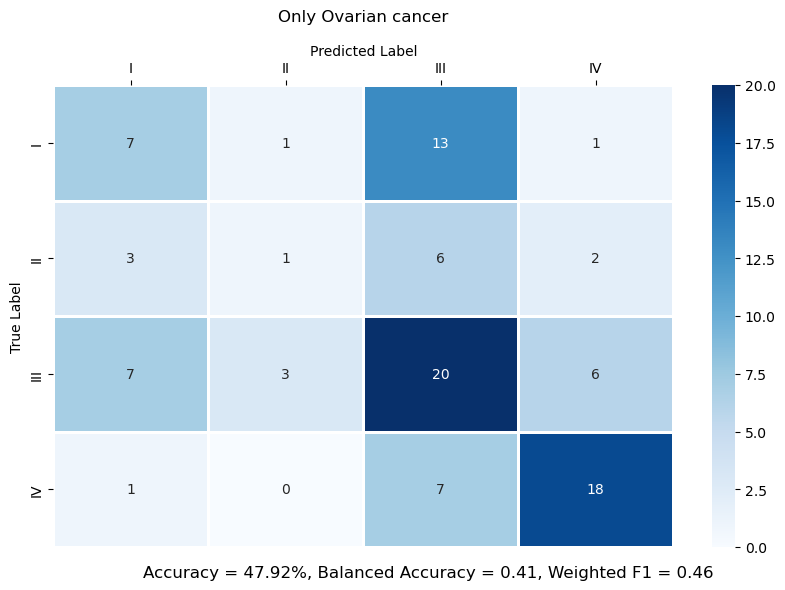

In [29]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'ovarian_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### PDAC


In [30]:
X_train = train.loc[train['Group'] == 'PDAC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

1    49
2    23
3    19
0     2
Name: Stage, dtype: int64

In [31]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 12:06:18,430] A new study created in memory with name: no-name-92e2cdbe-ed75-4c0a-92f3-593a5a1c2800
[I 2023-10-21 12:06:19,522] Trial 0 finished with value: 0.3179220085470085 and parameters: {'n_estimators': 24, 'max_depth': 7, 'learning_rate': 0.3775472417285872, 'subsample': 0.9618742084956955, 'colsample_bytree': 0.7544192425897255, 'gamma': 3.654572624861317}. Best is trial 0 with value: 0.3179220085470085.
[I 2023-10-21 12:06:23,405] Trial 1 finished with value: 0.32422542735042736 and parameters: {'n_estimators': 141, 'max_depth': 4, 'learning_rate': 0.3774461326835642, 'subsample': 0.9989927954999892, 'colsample_bytree': 0.7280101863110329, 'gamma': 3.046398684344952}. Best is trial 1 with value: 0.32422542735042736.
[I 2023-10-21 12:06:27,236] Trial 2 finished with value: 0.31022970085470086 and parameters: {'n_estimators': 110, 'max_depth': 8, 'learning_rate': 0.061892308478937626, 'subsample': 0.5461229677217609, 'colsample_bytree': 0.5715307380289999, 'gamma':

[I 2023-10-21 12:07:37,534] Trial 25 finished with value: 0.36196581196581196 and parameters: {'n_estimators': 130, 'max_depth': 6, 'learning_rate': 0.39146982321633533, 'subsample': 0.9900349856952977, 'colsample_bytree': 0.8448244102203024, 'gamma': 2.470564410965473}. Best is trial 25 with value: 0.36196581196581196.
[I 2023-10-21 12:07:40,932] Trial 26 finished with value: 0.3140491452991453 and parameters: {'n_estimators': 127, 'max_depth': 6, 'learning_rate': 0.4582160259551592, 'subsample': 0.7547788810008552, 'colsample_bytree': 0.8917729835907136, 'gamma': 2.3110716766655823}. Best is trial 25 with value: 0.36196581196581196.
[I 2023-10-21 12:07:43,580] Trial 27 finished with value: 0.28365384615384615 and parameters: {'n_estimators': 94, 'max_depth': 7, 'learning_rate': 0.4022314699857015, 'subsample': 0.8232163217564269, 'colsample_bytree': 0.8500062424186003, 'gamma': 2.55154514170321}. Best is trial 25 with value: 0.36196581196581196.
[I 2023-10-21 12:07:46,131] Trial 28 f

[I 2023-10-21 12:08:51,817] Trial 50 finished with value: 0.25587606837606836 and parameters: {'n_estimators': 131, 'max_depth': 6, 'learning_rate': 0.4745955397620528, 'subsample': 0.9821928285563749, 'colsample_bytree': 0.753656312558376, 'gamma': 3.107087216901355}. Best is trial 36 with value: 0.3825053418803419.
[I 2023-10-21 12:08:54,370] Trial 51 finished with value: 0.322542735042735 and parameters: {'n_estimators': 95, 'max_depth': 7, 'learning_rate': 0.44345855539474033, 'subsample': 0.8999598289125269, 'colsample_bytree': 0.7785084653776397, 'gamma': 2.5443813711433583}. Best is trial 36 with value: 0.3825053418803419.
[I 2023-10-21 12:08:56,945] Trial 52 finished with value: 0.36901709401709404 and parameters: {'n_estimators': 95, 'max_depth': 7, 'learning_rate': 0.41419192206836525, 'subsample': 0.8855756454088264, 'colsample_bytree': 0.7865778995978461, 'gamma': 2.427361613128239}. Best is trial 36 with value: 0.3825053418803419.
[I 2023-10-21 12:08:59,430] Trial 53 finis

[I 2023-10-21 12:10:06,183] Trial 75 finished with value: 0.3442040598290599 and parameters: {'n_estimators': 146, 'max_depth': 7, 'learning_rate': 0.45301015483488044, 'subsample': 0.9947784846272207, 'colsample_bytree': 0.8357032863299947, 'gamma': 2.1856254297666524}. Best is trial 36 with value: 0.3825053418803419.
[I 2023-10-21 12:10:09,792] Trial 76 finished with value: 0.30635683760683763 and parameters: {'n_estimators': 138, 'max_depth': 8, 'learning_rate': 0.4317000064343305, 'subsample': 0.9998601550345981, 'colsample_bytree': 0.8165366324041692, 'gamma': 2.6672678707754844}. Best is trial 36 with value: 0.3825053418803419.
[I 2023-10-21 12:10:13,120] Trial 77 finished with value: 0.2936698717948718 and parameters: {'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.38919900605574526, 'subsample': 0.963668802046795, 'colsample_bytree': 0.9155882993878928, 'gamma': 1.8318692781012327}. Best is trial 36 with value: 0.3825053418803419.
[I 2023-10-21 12:10:16,713] Trial 78 f

In [32]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.00      0.00      0.00         2
          II       0.54      0.84      0.66        49
         III       0.17      0.09      0.11        23
          IV       0.40      0.11      0.17        19

    accuracy                           0.48        93
   macro avg       0.28      0.26      0.23        93
weighted avg       0.41      0.48      0.41        93



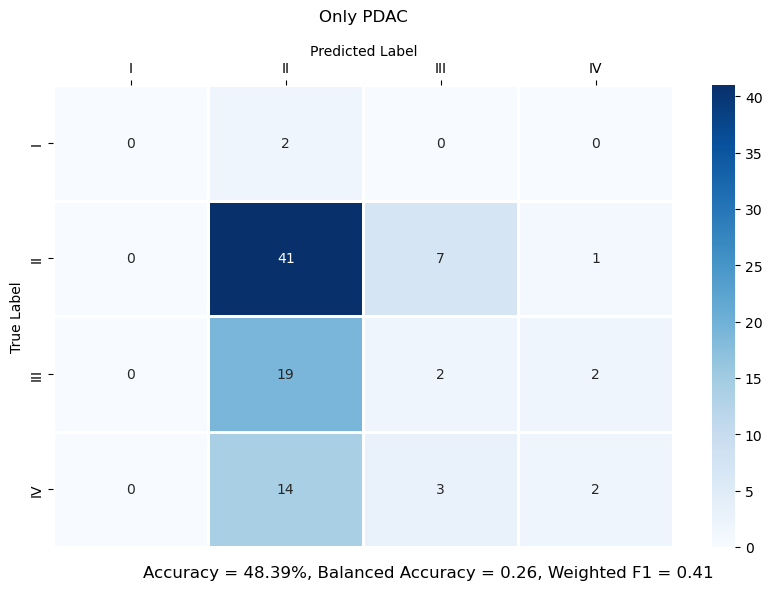

In [33]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only PDAC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'pdac_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

## Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

In [34]:
mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}

labels_encoding = {
    'I-III': 0,
    'IV': 1
}

xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0
}

### NSCLC

In [35]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

1    220
0     39
Name: Stage, dtype: int64

In [36]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 12:11:33,009] A new study created in memory with name: no-name-9de5fa28-93ae-42c2-9f76-cb50acde2197
[I 2023-10-21 12:11:35,303] Trial 0 finished with value: 0.5664141414141415 and parameters: {'n_estimators': 102, 'max_depth': 5, 'learning_rate': 0.422000996723953, 'subsample': 0.5514566524078564, 'colsample_bytree': 0.8834554946209485, 'gamma': 4.612694204048546}. Best is trial 0 with value: 0.5664141414141415.
[I 2023-10-21 12:11:36,298] Trial 1 finished with value: 0.6371212121212121 and parameters: {'n_estimators': 23, 'max_depth': 6, 'learning_rate': 0.39995567964518314, 'subsample': 0.9155481012507084, 'colsample_bytree': 0.581737715205999, 'gamma': 4.515610164812214}. Best is trial 1 with value: 0.6371212121212121.
[I 2023-10-21 12:11:38,559] Trial 2 finished with value: 0.5959595959595959 and parameters: {'n_estimators': 97, 'max_depth': 8, 'learning_rate': 0.3198522867886483, 'subsample': 0.6519920103719146, 'colsample_bytree': 0.9497343330092953, 'gamma': 2.5720

[I 2023-10-21 12:12:19,894] Trial 25 finished with value: 0.5718434343434343 and parameters: {'n_estimators': 53, 'max_depth': 4, 'learning_rate': 0.3284363133481641, 'subsample': 0.747968498013516, 'colsample_bytree': 0.5942812209327024, 'gamma': 4.9083906704316345}. Best is trial 1 with value: 0.6371212121212121.
[I 2023-10-21 12:12:22,318] Trial 26 finished with value: 0.5638888888888889 and parameters: {'n_estimators': 90, 'max_depth': 6, 'learning_rate': 0.00270215828858672, 'subsample': 0.8083041298664773, 'colsample_bytree': 0.6548574896811723, 'gamma': 4.380659018762332}. Best is trial 1 with value: 0.6371212121212121.
[I 2023-10-21 12:12:23,836] Trial 27 finished with value: 0.5893939393939395 and parameters: {'n_estimators': 72, 'max_depth': 5, 'learning_rate': 0.2864238582687415, 'subsample': 0.864129487778954, 'colsample_bytree': 0.5296693060606683, 'gamma': 3.7429590295983903}. Best is trial 1 with value: 0.6371212121212121.
[I 2023-10-21 12:12:25,244] Trial 28 finished wi

[I 2023-10-21 12:13:08,998] Trial 50 finished with value: 0.6166666666666666 and parameters: {'n_estimators': 133, 'max_depth': 8, 'learning_rate': 0.4364174049457002, 'subsample': 0.8938069181002669, 'colsample_bytree': 0.5049108791445329, 'gamma': 2.845543440478023}. Best is trial 44 with value: 0.6532828282828282.
[I 2023-10-21 12:13:11,361] Trial 51 finished with value: 0.6098484848484849 and parameters: {'n_estimators': 124, 'max_depth': 8, 'learning_rate': 0.37197511598885313, 'subsample': 0.8501243012910384, 'colsample_bytree': 0.5009742917103936, 'gamma': 2.061504113839978}. Best is trial 44 with value: 0.6532828282828282.
[I 2023-10-21 12:13:13,998] Trial 52 finished with value: 0.6178030303030302 and parameters: {'n_estimators': 141, 'max_depth': 7, 'learning_rate': 0.4118504399222861, 'subsample': 0.9151323690822569, 'colsample_bytree': 0.536909856268351, 'gamma': 2.390502420332595}. Best is trial 44 with value: 0.6532828282828282.
[I 2023-10-21 12:13:16,322] Trial 53 finish

[I 2023-10-21 12:14:10,429] Trial 75 finished with value: 0.608459595959596 and parameters: {'n_estimators': 113, 'max_depth': 5, 'learning_rate': 0.4994078380272521, 'subsample': 0.7789667503492342, 'colsample_bytree': 0.5474759989615358, 'gamma': 1.516438862910307}. Best is trial 66 with value: 0.6626262626262627.
[I 2023-10-21 12:14:13,002] Trial 76 finished with value: 0.6246212121212121 and parameters: {'n_estimators': 148, 'max_depth': 6, 'learning_rate': 0.46577271073830157, 'subsample': 0.8132389450664815, 'colsample_bytree': 0.5790782210274775, 'gamma': 2.0598251596607726}. Best is trial 66 with value: 0.6626262626262627.
[I 2023-10-21 12:14:15,280] Trial 77 finished with value: 0.608459595959596 and parameters: {'n_estimators': 98, 'max_depth': 6, 'learning_rate': 0.4170003951696049, 'subsample': 0.8674243655365368, 'colsample_bytree': 0.6328635254418356, 'gamma': 1.8685626463580955}. Best is trial 66 with value: 0.6626262626262627.
[I 2023-10-21 12:14:17,396] Trial 78 finish

In [37]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.73      0.21      0.32        39
          IV       0.88      0.99      0.93       220

    accuracy                           0.87       259
   macro avg       0.80      0.60      0.62       259
weighted avg       0.85      0.87      0.84       259



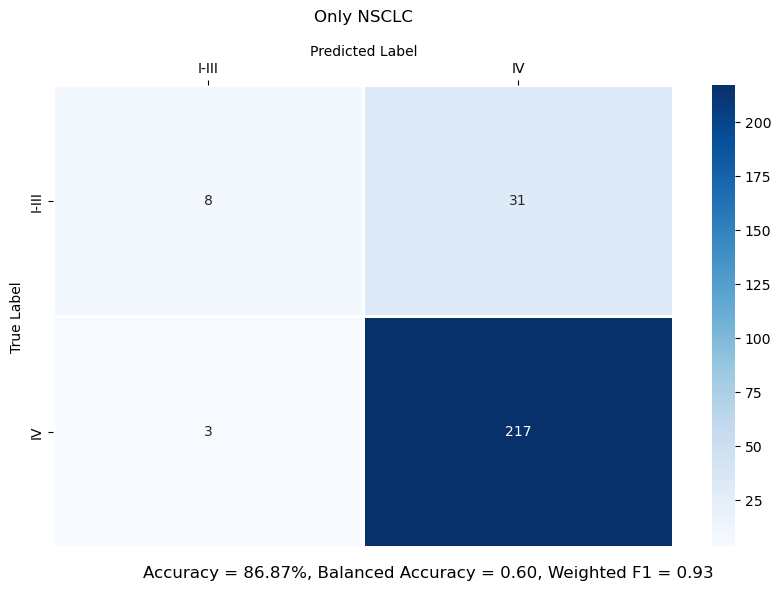

In [38]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'nsclc_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### Ovarian cancer

In [39]:
X_train = train.loc[train['Group'] == 'ovarianCancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    70
1    26
Name: Stage, dtype: int64

In [40]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 12:15:08,814] A new study created in memory with name: no-name-13593c63-3d1a-4d2b-8572-ef17db6a4a61
[I 2023-10-21 12:15:10,868] Trial 0 finished with value: 0.8091153127917834 and parameters: {'n_estimators': 93, 'max_depth': 3, 'learning_rate': 0.11227558921831425, 'subsample': 0.7799627241929994, 'colsample_bytree': 0.6500785664043227, 'gamma': 1.0972767687052065}. Best is trial 0 with value: 0.8091153127917834.
[I 2023-10-21 12:15:12,319] Trial 1 finished with value: 0.8087068160597572 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.329353047206889, 'subsample': 0.6844131166340539, 'colsample_bytree': 0.6099963401007271, 'gamma': 2.224585372439351}. Best is trial 0 with value: 0.8091153127917834.
[I 2023-10-21 12:15:13,626] Trial 2 finished with value: 0.7207633053221288 and parameters: {'n_estimators': 36, 'max_depth': 2, 'learning_rate': 0.40526344058411756, 'subsample': 0.5031112724181734, 'colsample_bytree': 0.92789897886862, 'gamma': 3.7811

[I 2023-10-21 12:15:58,465] Trial 25 finished with value: 0.7247899159663865 and parameters: {'n_estimators': 91, 'max_depth': 8, 'learning_rate': 0.09369974935981668, 'subsample': 0.7144393162228224, 'colsample_bytree': 0.6372198166497901, 'gamma': 3.5922937736474183}. Best is trial 21 with value: 0.8269724556489262.
[I 2023-10-21 12:15:59,957] Trial 26 finished with value: 0.7287581699346406 and parameters: {'n_estimators': 42, 'max_depth': 6, 'learning_rate': 0.13660519056277914, 'subsample': 0.7762879326432188, 'colsample_bytree': 0.5861288628125635, 'gamma': 4.253997957383957}. Best is trial 21 with value: 0.8269724556489262.
[I 2023-10-21 12:16:01,422] Trial 27 finished with value: 0.7525676937441642 and parameters: {'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.03636373315138838, 'subsample': 0.8082468673292321, 'colsample_bytree': 0.6469215207248452, 'gamma': 4.79767591273266}. Best is trial 21 with value: 0.8269724556489262.
[I 2023-10-21 12:16:04,072] Trial 28 finish

[I 2023-10-21 12:16:40,997] Trial 50 finished with value: 0.6821311858076564 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.16144837390210767, 'subsample': 0.6740744884440192, 'colsample_bytree': 0.6335795041965723, 'gamma': 4.6967765408757245}. Best is trial 21 with value: 0.8269724556489262.
[I 2023-10-21 12:16:43,485] Trial 51 finished with value: 0.78828197945845 and parameters: {'n_estimators': 109, 'max_depth': 2, 'learning_rate': 0.09023619949396254, 'subsample': 0.7439166017328617, 'colsample_bytree': 0.5338718681347706, 'gamma': 1.3581848232195801}. Best is trial 21 with value: 0.8269724556489262.
[I 2023-10-21 12:16:46,248] Trial 52 finished with value: 0.8269724556489262 and parameters: {'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.07863311224054578, 'subsample': 0.7697732711092224, 'colsample_bytree': 0.5184524590731752, 'gamma': 0.6126608017550722}. Best is trial 21 with value: 0.8269724556489262.
[I 2023-10-21 12:16:49,167] Trial 53 fin

[I 2023-10-21 12:17:34,847] Trial 75 finished with value: 0.7109010270774977 and parameters: {'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.10151570366189919, 'subsample': 0.7448481378810333, 'colsample_bytree': 0.7656426236931866, 'gamma': 3.4678301839422643}. Best is trial 21 with value: 0.8269724556489262.
[I 2023-10-21 12:17:37,379] Trial 76 finished with value: 0.7555438842203548 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.02884982401421693, 'subsample': 0.7566491403884079, 'colsample_bytree': 0.779541993691251, 'gamma': 4.172747350043427}. Best is trial 21 with value: 0.8269724556489262.
[I 2023-10-21 12:17:38,884] Trial 77 finished with value: 0.7882819794584499 and parameters: {'n_estimators': 45, 'max_depth': 3, 'learning_rate': 0.049564467118357644, 'subsample': 0.7098283176036184, 'colsample_bytree': 0.6058578584260634, 'gamma': 4.336590100825483}. Best is trial 21 with value: 0.8269724556489262.
[I 2023-10-21 12:17:40,701] Trial 78 fini

In [41]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.83      0.93      0.88        70
          IV       0.72      0.50      0.59        26

    accuracy                           0.81        96
   macro avg       0.78      0.71      0.73        96
weighted avg       0.80      0.81      0.80        96



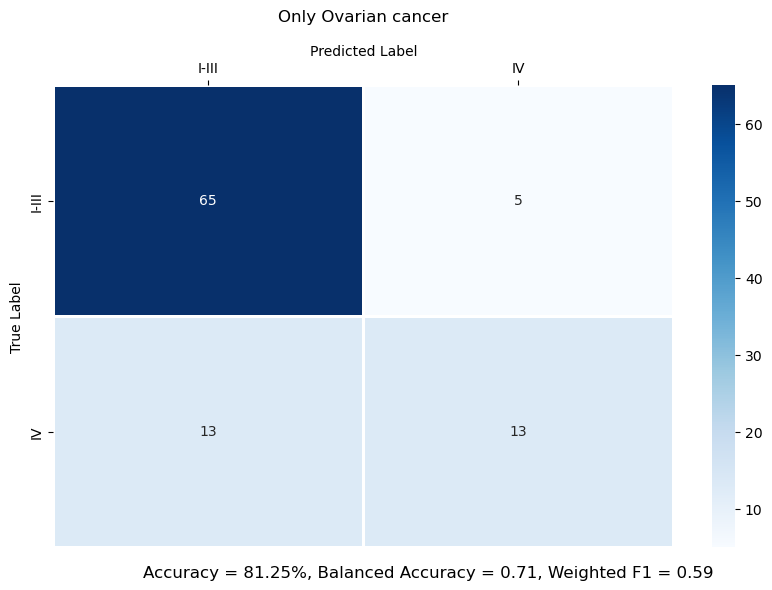

In [42]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'ovarian_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### PDAC

In [43]:
X_train = train.loc[train['Group'] == 'PDAC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    74
1    19
Name: Stage, dtype: int64

In [44]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 12:18:12,694] A new study created in memory with name: no-name-412d5084-92ab-4c71-9637-dbd105bebfa5
[I 2023-10-21 12:18:15,141] Trial 0 finished with value: 0.4666666666666667 and parameters: {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.3946963828751857, 'subsample': 0.9442454448364801, 'colsample_bytree': 0.9516667735513737, 'gamma': 3.774786706513547}. Best is trial 0 with value: 0.4666666666666667.
[I 2023-10-21 12:18:17,228] Trial 1 finished with value: 0.4930555555555556 and parameters: {'n_estimators': 82, 'max_depth': 4, 'learning_rate': 0.06492370553541527, 'subsample': 0.5281397943805388, 'colsample_bytree': 0.6364966489602444, 'gamma': 3.396168860356445}. Best is trial 1 with value: 0.4930555555555556.
[I 2023-10-21 12:18:19,907] Trial 2 finished with value: 0.5673611111111111 and parameters: {'n_estimators': 99, 'max_depth': 6, 'learning_rate': 0.22078696406597637, 'subsample': 0.8562614868161584, 'colsample_bytree': 0.9206877240152493, 'gamma': 1.2

[I 2023-10-21 12:19:12,058] Trial 25 finished with value: 0.5423611111111112 and parameters: {'n_estimators': 146, 'max_depth': 5, 'learning_rate': 0.24438135896766666, 'subsample': 0.6723766255707386, 'colsample_bytree': 0.8551417677575776, 'gamma': 3.0755619623886625}. Best is trial 2 with value: 0.5673611111111111.
[I 2023-10-21 12:19:14,613] Trial 26 finished with value: 0.49722222222222223 and parameters: {'n_estimators': 114, 'max_depth': 8, 'learning_rate': 0.26557889829410863, 'subsample': 0.7161648254148585, 'colsample_bytree': 0.7658660749521737, 'gamma': 3.88745516026404}. Best is trial 2 with value: 0.5673611111111111.
[I 2023-10-21 12:19:16,620] Trial 27 finished with value: 0.46805555555555556 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.32844958449660294, 'subsample': 0.5508457616022271, 'colsample_bytree': 0.8399752182061561, 'gamma': 2.973122384777106}. Best is trial 2 with value: 0.5673611111111111.
[I 2023-10-21 12:19:18,891] Trial 28 finis

[I 2023-10-21 12:20:17,229] Trial 50 finished with value: 0.5083333333333333 and parameters: {'n_estimators': 81, 'max_depth': 8, 'learning_rate': 0.4666300231419275, 'subsample': 0.7259991407299787, 'colsample_bytree': 0.8839248030832616, 'gamma': 2.5232815360941903}. Best is trial 2 with value: 0.5673611111111111.
[I 2023-10-21 12:20:19,780] Trial 51 finished with value: 0.5243055555555556 and parameters: {'n_estimators': 120, 'max_depth': 8, 'learning_rate': 0.12751540512444412, 'subsample': 0.7571210943991211, 'colsample_bytree': 0.9529149539832438, 'gamma': 4.343248014026317}. Best is trial 2 with value: 0.5673611111111111.
[I 2023-10-21 12:20:22,328] Trial 52 finished with value: 0.5243055555555556 and parameters: {'n_estimators': 117, 'max_depth': 8, 'learning_rate': 0.11154409889125572, 'subsample': 0.7731001727112923, 'colsample_bytree': 0.9771943794602419, 'gamma': 4.7440895755114285}. Best is trial 2 with value: 0.5673611111111111.
[I 2023-10-21 12:20:24,745] Trial 53 finish

[I 2023-10-21 12:21:45,760] Trial 75 finished with value: 0.45347222222222217 and parameters: {'n_estimators': 94, 'max_depth': 2, 'learning_rate': 0.2692446884625394, 'subsample': 0.7374612800491597, 'colsample_bytree': 0.86162023892567, 'gamma': 2.7301806606328913}. Best is trial 2 with value: 0.5673611111111111.
[I 2023-10-21 12:21:47,376] Trial 76 finished with value: 0.4736111111111111 and parameters: {'n_estimators': 22, 'max_depth': 3, 'learning_rate': 0.19615303496076808, 'subsample': 0.6201239537949742, 'colsample_bytree': 0.8275206451436542, 'gamma': 1.0325436405367898}. Best is trial 2 with value: 0.5673611111111111.
[I 2023-10-21 12:21:50,558] Trial 77 finished with value: 0.5041666666666667 and parameters: {'n_estimators': 87, 'max_depth': 8, 'learning_rate': 0.08455053434509174, 'subsample': 0.6645540271842654, 'colsample_bytree': 0.8117863961224636, 'gamma': 2.108070763329905}. Best is trial 2 with value: 0.5673611111111111.
[I 2023-10-21 12:21:54,358] Trial 78 finished 

In [45]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.80      0.95      0.86        74
          IV       0.20      0.05      0.08        19

    accuracy                           0.76        93
   macro avg       0.50      0.50      0.47        93
weighted avg       0.67      0.76      0.70        93



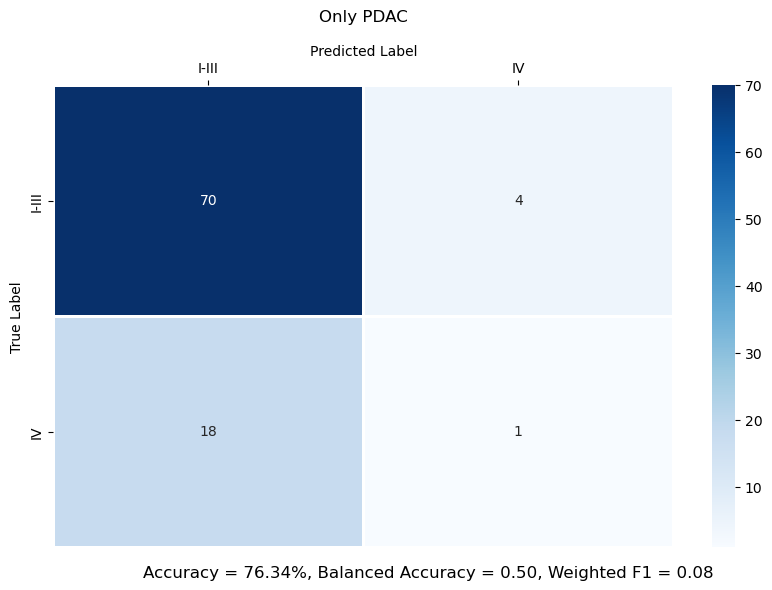

In [46]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only PDAC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'pdac_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))